### 1.Problem Statement
#### Create a model for predict that coment/text belongs to which type of emotion (fear/angry/joy)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob as tb
from autocorrect import Speller as sp
import emoji
import nltk
from nltk.tokenize import word_tokenize as wt,sent_tokenize as st
from nltk.corpus import stopwords
from nltk import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.pipeline import Pipeline ,make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer,PowerTransformer

In [2]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=857a0d6f7c173422f11d08495af9fbfee5f7eff87bae88bdc81e7f342684869e
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [3]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 7.0 MB/s eta 0:00:00


In [5]:
pip install nltk

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### 2.Data Collection

In [9]:
# take a data set from kaggle which used to classify emotions based on text/comments.
# Convert column names correctly as mensioned in problem statement.
data = pd.read_csv(r"/content/drive/MyDrive/Emotion_classify_Data.csv")
data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


### 3.EDA Before pre-processing

In [10]:
data.shape   # data contains 5937 rows and 2 columns

(5937, 2)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [12]:
data.isnull().sum()     # in this data doesn't have any missing values

Comment    0
Emotion    0
dtype: int64

In [13]:
data.duplicated().sum()     # this data doesn't have any duplicate values

0

In [14]:
data.Emotion.unique()   # unique values for class label of emotions

array(['fear', 'anger', 'joy'], dtype=object)

In [15]:
data.Emotion.value_counts() # 2000 rows belongs to anger , 2000 rows belongs to joy and 1937 rows belongs to fear

anger    2000
joy      2000
fear     1937
Name: Emotion, dtype: int64

In [16]:
# as per my problem statement i don't want some columns,beacuase there is no use for those columns for solve my problem statemnet
# split my data into featue variables and class variables
fv = data.iloc[:,0]
cv = data.iloc[:,-1]

In [17]:
fv.head()

0    i seriously hate one subject to death but now ...
1                   im so full of life i feel appalled
2    i sit here to write i start to dig out my feel...
3    ive been really angry with r and i feel like a...
4    i feel suspicious if there is no one outside l...
Name: Comment, dtype: object

In [18]:
cv= cv.map({"anger":0,"joy":2,"fear":1})    # Covert class labels anger as 0 , joy as 2 and fear as 1

In [19]:
cv.head()

0    1
1    0
2    1
3    2
4    1
Name: Emotion, dtype: int64

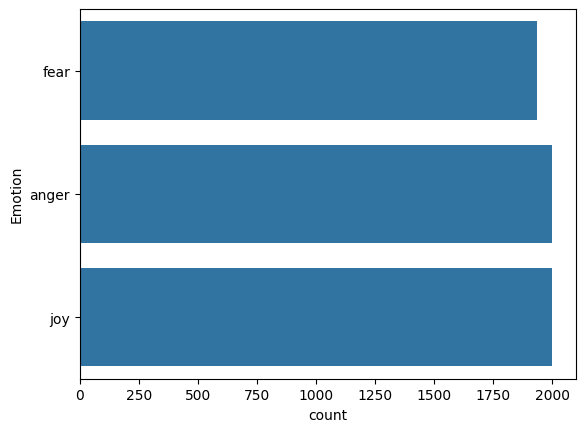

In [20]:
sns.countplot(data.Emotion)
plt.show()

In [21]:
# split my data into x_train and x_test
x_train,x_test,y_train,y_test = train_test_split(fv,cv,test_size=0.2,stratify=cv)

In [22]:
x_train.shape     # x_train data contains 4749 rows

(4749,)

In [23]:
x_test.shape      # x_test data contains 1188 rows

(1188,)

### 4. Pre-processing

In [24]:
# basic pre=processing steps

def lowers(x):
    return x.str.lower()

def html(x):
    return x.apply(lambda x:re.sub("<.+?>"," ",x))

def url(x):
    return x.apply(lambda x:re.sub("https[s]?://.+? +"," ",x))

def unw(x):
    return x.apply(lambda x:re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

def emoji_remove(x):

    x = x.apply(lambda x : emoji.demojize(x))

    return x

In [25]:
def lemma(x):
  list_stp = stopwords.words("english")  # list_stp contains group of stop words.
  wl=WordNetLemmatizer()

  def lemmatize_text(text):
        words = wt(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]
        return " ".join(lemmatized_words)

  return x.apply(lemmatize_text)

In [26]:
lemma(fv)

0       seriously hate one subject death feel reluctan...
1                                 im full life feel appal
2       sit write start dig feel think afraid accept p...
3       ive really angry r feel like idiot trust first...
4       feel suspicious one outside like rapture happe...
                              ...                        
5932                                  begin feel distress
5933      leave feel annoy angry think center stupid joke
5934    ever get marry everything ready offer get toge...
5935    feel reluctant apply want able find company kn...
5936             want apologize feel like heartless bitch
Name: Comment, Length: 5937, dtype: object

In [27]:
# create a pipeline for pre-processing the data
pre_pro_pi = Pipeline([("Emoji's", FunctionTransformer(emoji_remove)),("lower",FunctionTransformer(lowers)),("html",FunctionTransformer(html)),
                       ("url",FunctionTransformer(url)),("unw",FunctionTransformer(unw)),("advance",FunctionTransformer(lemma))])

In [28]:
pre_pro_pi

Pipeline(steps=[("Emoji's",
                 FunctionTransformer(func=<function emoji_remove at 0x7aa63c2cce50>)),
                ('lower',
                 FunctionTransformer(func=<function lowers at 0x7aa6049705e0>)),
                ('html',
                 FunctionTransformer(func=<function html at 0x7aa621479ea0>)),
                ('url',
                 FunctionTransformer(func=<function url at 0x7aa621479c60>)),
                ('unw',
                 FunctionTransformer(func=<function unw at 0x7aa603ddbeb0>)),
                ('advance',
                 FunctionTransformer(func=<function lemma at 0x7aa604aeff40>))])

In [29]:
final_pipe = Pipeline([("pre_process",pre_pro_pi),("vectorizer",CountVectorizer())])

In [30]:
final_pipe.fit_transform(x_train)

<4749x6342 sparse matrix of type '<class 'numpy.int64'>'
	with 42835 stored elements in Compressed Sparse Row format>

In [31]:
import pickle
pickle.dump(final_pipe,open(r"/content/drive/MyDrive/emotions_pre1.pkl","wb"))

### 5.EDA after pre-processing
we are perform on text data,so this is totally based on frequency of words or frequency of chracters or most common words based on types of Targets

In [32]:
xtrain_pre = pre_pro_pi.fit_transform(x_train)

In [33]:
featur_var = pd.DataFrame(xtrain_pre,columns=["Comment"])
class_var = pd.DataFrame(y_train,columns = ["Emotion"])

df = pd.concat([featur_var,class_var],axis=1)    # concat fv and data["Target"] as new data frame
df.head()

,Comment,Emotion
665,feel irate extremely uncomfortable,0
5753,feel mad didnt reply get worry,0
4962,present two photos side side one photo remembe...,2
1104,im feel jealous think wrap clean warm soft,0
5134,feel look gorgeous beautiful sexy,2


In [34]:
df["Emotion"] = df["Emotion"].map({0:"anger",2:"joy",1:"fear"})

In [35]:
df.head()

,Comment,Emotion
665,feel irate extremely uncomfortable,anger
5753,feel mad didnt reply get worry,anger
4962,present two photos side side one photo remembe...,joy
1104,im feel jealous think wrap clean warm soft,anger
5134,feel look gorgeous beautiful sexy,joy


In [36]:
# seperate data into Targets.
gp = df.groupby("Emotion")
anger = gp.get_group("anger")["Comment"]
fear = gp.get_group("joy")["Comment"]
joy = gp.get_group("fear")["Comment"]

In [37]:
gp.get_group("anger")["Comment"]

665                    feel irate extremely uncomfortable
5753                       feel mad didnt reply get worry
1104           im feel jealous think wrap clean warm soft
5638    also know forget period time would cause tensi...
1552    know signify feel dangerous secure relax guess...
                              ...                        
5233    feel greedy obsession continue sustainabilitys...
3208            feel mad connection body decide kick side
3367    think wont affect youre think feel petty side ...
3654                            really feel bother honest
3361                   feel resentful sun chase house day
Name: Comment, Length: 1600, dtype: object

In [38]:
# Combine entire rows text into one text
ft = " ".join(gp.get_group("anger")["Comment"]).split()
jt = " ".join(gp.get_group("joy")["Comment"]).split()
at = " ".join(gp.get_group("fear")["Comment"]).split()


In [39]:
# find how many words contain each emotion
print("anger class contains",len(ft),"number of words")
print("joy class contains",len(jt),"number of words")
print("fear class contains",len(at),"number of words")

anger class contains 14932 number of words
joy class contains 15427 number of words
fear class contains 14178 number of words


### find top most common words in each class

In [40]:
pip install wordcloud

In [41]:
from collections import Counter
Counter(ft).most_common(10)

[('feel', 1675),
 ('like', 272),
 ('im', 255),
 ('get', 170),
 ('make', 109),
 ('time', 104),
 ('want', 103),
 ('go', 99),
 ('think', 97),
 ('know', 97)]

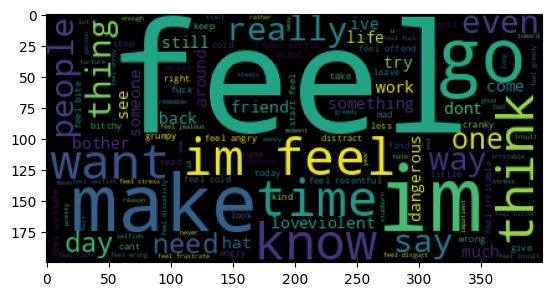

In [42]:
from wordcloud import WordCloud
wc = WordCloud().generate(" ".join(gp.get_group("anger")["Comment"]))
plt.imshow(wc)
plt.show()

In [43]:
Counter(jt).most_common(10)

[('feel', 1688),
 ('like', 316),
 ('im', 230),
 ('get', 145),
 ('make', 141),
 ('go', 101),
 ('want', 98),
 ('time', 90),
 ('know', 84),
 ('really', 83)]

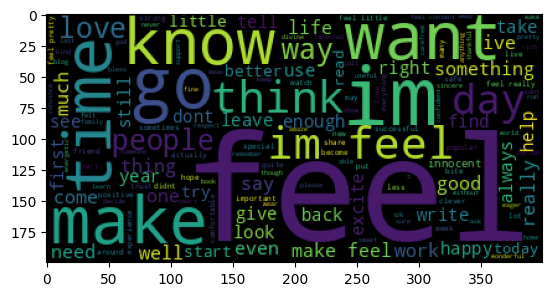

In [44]:
from wordcloud import WordCloud
wc = WordCloud().generate(" ".join(gp.get_group("joy")["Comment"]))
plt.imshow(wc)
plt.show()

In [45]:
Counter(at).most_common(10)

[('feel', 1619),
 ('im', 258),
 ('like', 223),
 ('go', 137),
 ('know', 119),
 ('little', 118),
 ('get', 110),
 ('make', 103),
 ('bite', 95),
 ('want', 95)]

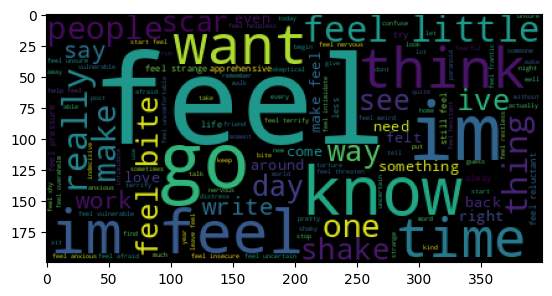

In [46]:
from wordcloud import WordCloud
wc = WordCloud().generate(" ".join(gp.get_group("fear")["Comment"]))
plt.imshow(wc)
plt.show()

### 6.Feature engineering

In [47]:
xtest_pre = pre_pro_pi.transform(x_test)
cv = CountVectorizer()    # it will take CountVectorizer function

### 7.Training

In [48]:
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,CategoricalNB

In [49]:
final_xtrain = final_pipe.fit_transform(x_train)
final_xtest = final_pipe.transform(x_test)

In [50]:
mb = MultinomialNB()
model = mb.fit(final_xtrain,y_train)

In [51]:
(final_xtrain)


<4749x6342 sparse matrix of type '<class 'numpy.int64'>'
	with 42835 stored elements in Compressed Sparse Row format>

In [52]:
pickle.dump(model,open(r"/content/drive/MyDrive/emotion_model1.pkl","wb"))

### 8.Model Evalution

In [53]:
from sklearn.metrics import accuracy_score , classification_report,confusion_matrix

In [54]:
accuracy_score(y_test,model.predict(final_xtest))  # By using multinominal it will give 90% of accuracy rate

0.8872053872053872

In [55]:
print(classification_report(y_test,model.predict(final_pipe.transform(x_test))) )

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       400
           1       0.86      0.89      0.88       388
           2       0.92      0.86      0.89       400

    accuracy                           0.89      1188
   macro avg       0.89      0.89      0.89      1188
weighted avg       0.89      0.89      0.89      1188



### 9.Testing

In [56]:
m = final_pipe.transform(pd.Series("i am very happy today.because i got job at top mnc company"))
pred = model.predict(m)   # it is used to shows that predicted value

if pred == 0:
    print("anger")
elif pred == 1:
  print("fear")
else:
    print("joy")

joy


finally I send a text as querry to the model,then it will give the result as real emotion of that text is "JOY"